In [1]:
# This example illustrates how to approximate some mass distribution as
# a sum of Plummer basis functions

In [2]:
# First, we'll import some modules and set some defaults
%matplotlib inline
import grale.lenses as lenses
import grale.images as images
import grale.feedback as feedback
import grale.grid as grid
import grale.renderers as renderers
import grale.plotutil as plotutil
import grale.gridfunction as gridfunction
from grale.cosmology import Cosmology
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

V = lambda x,y: np.array([x,y],dtype=np.double)
LI = plotutil.LensInfo
DI = plotutil.DensInfo

feedback.setDefaultFeedback("none")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)
renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")

cosm = Cosmology(0.7,0.3,0,0.7)

In [3]:
# The lens that we're going to approximate as a sum of Plummer basis functions
# will be a PIEMD lens
zd = 0.5
zs = 2.0

Dd = cosm.getAngularDiameterDistance(zd)
Dds = cosm.getAngularDiameterDistance(zd,zs)
Ds = cosm.getAngularDiameterDistance(zs)
critDens = lenses.getCriticalDensity(Dd, Ds, Dds)

l = lenses.PIEMDLens(Dd, { 
    "centraldensity": 30*critDens,
    "coreradius": 0.5*ANGLE_ARCSEC,
    "scaleradius": 50*ANGLE_ARCSEC,
    "epsilon": 0.3})

In [4]:
lensInfo = LI(lens=l, Dds=Dds, Ds=Ds, size=160*ANGLE_ARCSEC, numxy=1023)

In [5]:
plotutil.plotDensityInteractive(lensInfo, numX=100, numY=100);

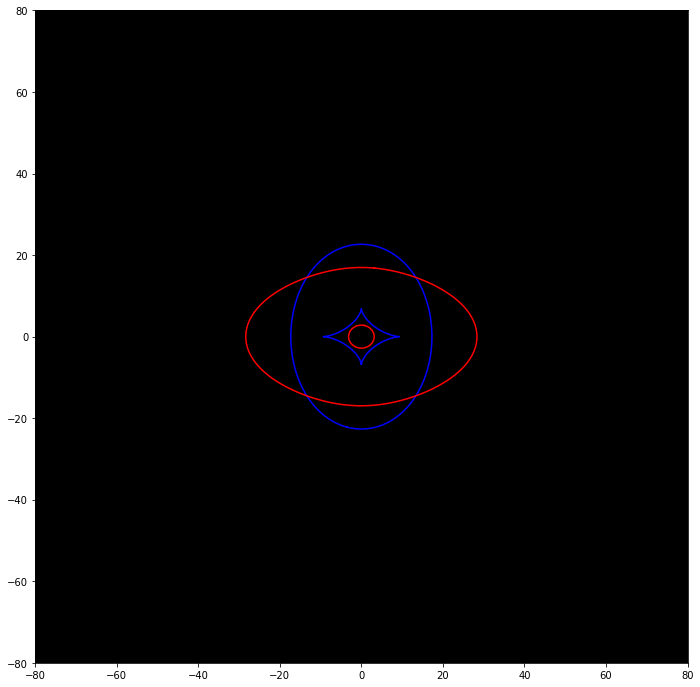

In [6]:
# The image plane for this lens
plt.figure(figsize=(12,12))
plotutil.plotImagePlane(lensInfo);

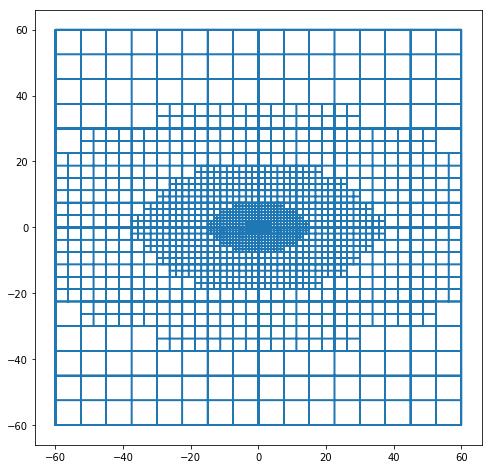

In [7]:
# Here, we're going to prepare the fit. We're going to create a grid of cells for
# which the cells are narrower in regions that contain more mass. We'll aim for
# between 2000 and 2200 cells.
# For each cell, in the next step we'll use a Plummer basis function with a width
# that's proportional to the cell size. When a cell is subdivided, we're keeping that
# cell in the grid as well (so not just the four smaller 'child' cells), thereby also using
# a basis function for the 'parent' cell.
N1, N2 = 2000, 2200
cells = grid.createSubdivisionGrid(120*ANGLE_ARCSEC, [0,0], lensInfo, N1, N2, keepLarger=True)

plt.figure(figsize=(8,8))
plotutil.plotSubdivisionGrid(cells);

In [8]:
# In the fitMultiplePlummerLens function, we not only need to specify
# the cells to which the Plummer basis functions should be assigned, but
# we also need to profide a function that returns the surface mass density
# for the points that are specified. In this case, that's provided by
# our original lens
fitLens = grid.fitMultiplePlummerLens(cells, Dd, l.getSurfaceMassDensity)

# The type of the new lens shows that it's a multiple plummer lens:
type(fitLens)

grale.lenses.MultiplePlummerLens

In [9]:
fitLensInfo = LI(lens=fitLens, Dds=Dds, Ds=Ds, **lensInfo.getArea(), numxy=1023)

In [10]:
# Taking a look at the density of the fitted lens shows that it looks very similar
plotutil.plotDensityInteractive(fitLensInfo, numX=100, numY=100);

In [11]:
# The difference between the two mass densities is quite small. Here we'll
# create a custom diffLensInfo dictionary that contains the difference of the
# previously calculated densities, which the plot routine will then show
diffLensInfo = DI(lensInfo.getDensityPoints()-fitLensInfo.getDensityPoints(), **lensInfo.getArea())
plotutil.plotDensityInteractive(diffLensInfo, numX=100, numY=100);

# Also show the min and max of these points (uses a finer grid than is shown in
# the 3D plot)
diffLensInfo.getDensityPoints().max(), diffLensInfo.getDensityPoints().min()

(0.4007610429236905, -0.6061951644657455)

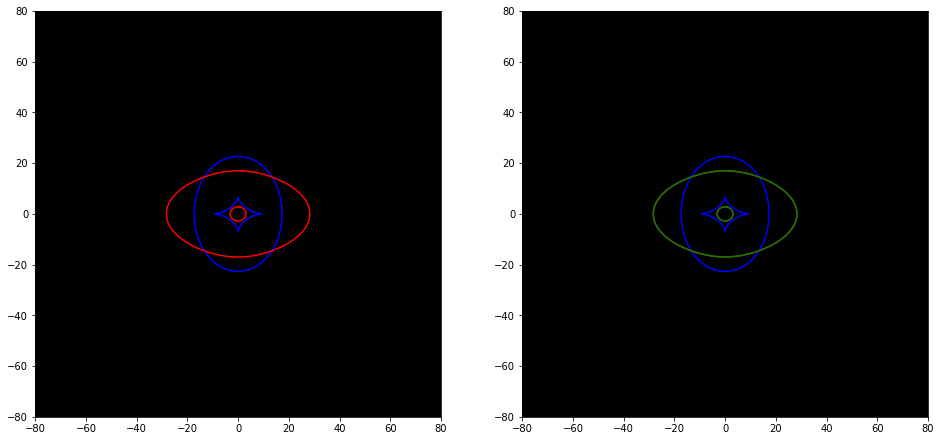

In [12]:
# Let's plot the image plane for the new lens on the left. On the right we'll
# first plot the same situation, and re-draw the critical lines of the original
# PIEMD lens in green, showing that they are very nearly identical
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotutil.plotImagePlane(fitLensInfo);

plt.subplot(1,2,2)
plotutil.plotImagePlane(fitLensInfo);

orig = lensInfo.getImagePlane().getCriticalLines()
for c in orig:
    plt.plot(np.array(c)[:,0]/ANGLE_ARCSEC, np.array(c)[:,1]/ANGLE_ARCSEC, color="green")

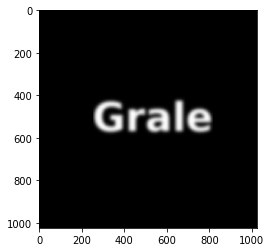

In [13]:
# Having verified that we can reproduce the lens effect well with such an
# approximation, let's have some fun with this. Here, we'll use a PNG image
# file that shows 'Grale' as a mass distribution.

# First, let's load the image and show its contents
img = plt.imread("grale.png")
plt.imshow(img)

# Then, to be able to easily plug this into the subdivision grid creation, as
# well as the fit routine, we'll create a GridFunction. As the image pixels are
# from top to bottom and we want them the other way around, we'll flip the image
# The x10 is done (after some experimenting) to get a total mass of roughly 1e13 M_sun
# in the region.
img = np.flip(img[:,:,0].astype(np.double)*10, 0)
gf = gridfunction.GridFunction(img, -V(20,20)*ANGLE_ARCSEC, V(20,20)*ANGLE_ARCSEC)

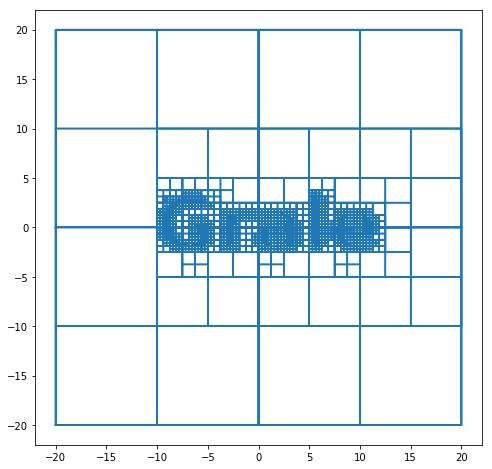

In [14]:
# We'll use a very similar routine to create the subdivision grid, where we
# specify that the newly created gridfunction is to be used to evaluate the
# densities
N1, N2 = 2000, 2200
cells = grid.createSubdivisionGridForFunction(gf.evaluate, 40*ANGLE_ARCSEC, [0,0], N1, N2, keepLarger=True)

plt.figure(figsize=(8,8))
plotutil.plotSubdivisionGrid(cells);

In [15]:
# Fit a multiple plummer lens to the grid function using these cells
fitLens = grid.fitMultiplePlummerLens(cells, Dd, gf.evaluate)

In [16]:
fitLensInfo = LI(lens=fitLens, Dds=Dds, Ds=Ds, size=40*ANGLE_ARCSEC, numxy=1023)

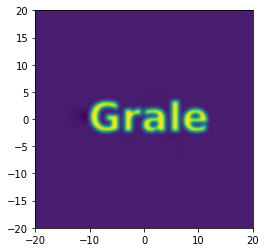

In [17]:
# A plot of this gravitational lens shows that the mass density indeed
# shows 'Grale'
plotutil.plotDensity(fitLensInfo);

In [18]:
# The total mass of this lens is roughly 1e13 M_sun
print("{:g}".format(fitLensInfo.getIntegratedMass()/MASS_SUN))

9.64107e+12


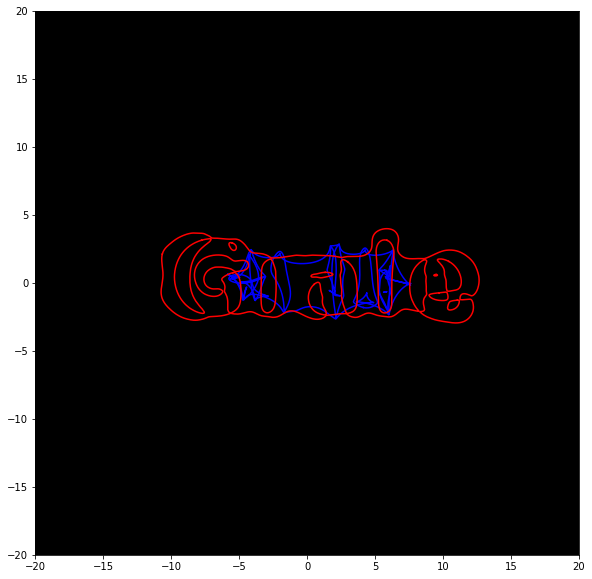

In [19]:
# Let's also calculate the image plane
plt.figure(figsize=(10,10))
plotutil.plotImagePlane(fitLensInfo);

In [20]:
# What's an image plane without a source? So, let's create a movie
# where we move a source and show the images that are created

src = images.CircularSource([0,0], 1*ANGLE_ARCSEC, fade=True)

class MyAnim(plotutil.NotebookAnimation):
    def __init__(self, numFrames):
        super(MyAnim, self).__init__("gralesource.mp4", [-15,5], [15,-5], numFrames, 15)

    def onDraw(self, pos, axes):
        src.setAngularPosition(np.array(pos)*ANGLE_ARCSEC)

        # This code is nearly the same as the code above, but here we're drawing to
        # the 'axes' object that's passed to the function.
        axes.clear()
        plotutil.plotImagePlane(fitLensInfo, [src], axes=axes);

In [21]:
plt.figure(figsize=(10,10))
MyAnim(400)

FloatProgress(value=1.0, max=400.0, min=1.0)

Text(value='')